In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import display
from scipy import optimize
import scipy.stats as stats

Reading in data

In [2]:
df=pd.read_csv('D:/Documents/CLS/thesis/ReinforcementLearninginMarketMaking_Thesis/code/data/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv')

In [3]:
df.head()

,exchange,symbol,timestamp,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,binance,DOGEUSDT,1735689601703988,1735689601703988,0.31601,126244,0.316,87917,0.31602,27345,...,0.31578,82614,0.31624,39742,0.31577,32204,0.31625,44537,0.31576,137603
1,binance,DOGEUSDT,1735689601974000,1735689601975707,0.31601,126244,0.316,87917,0.31602,30507,...,0.31578,82614,0.31624,39742,0.31577,32204,0.31625,44537,0.31576,137603
2,binance,DOGEUSDT,1735689602074000,1735689602075995,0.31601,126244,0.316,87917,0.31602,30507,...,0.31578,82614,0.31624,39742,0.31577,32204,0.31625,44537,0.31576,137603
3,binance,DOGEUSDT,1735689602274000,1735689602275736,0.31601,115444,0.316,87917,0.31602,32089,...,0.31578,82614,0.31624,39742,0.31577,32204,0.31625,44537,0.31576,137603
4,binance,DOGEUSDT,1735689602374000,1735689602375702,0.31601,115444,0.316,87917,0.31602,32880,...,0.31578,82614,0.31624,39742,0.31577,32204,0.31625,44537,0.31576,137603


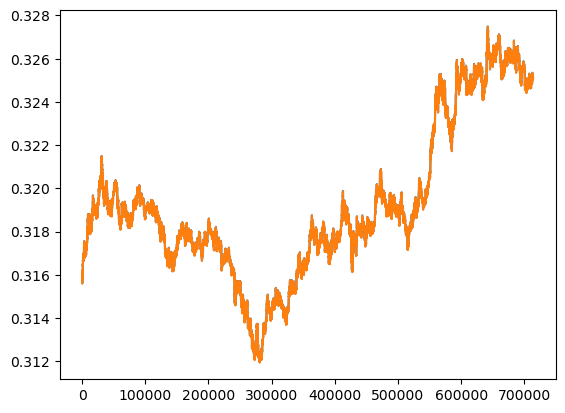

In [4]:
plt.plot(df.index, df["asks[0].price"])
plt.plot(df.index, df["bids[0].price"])

Preprocessing data

In [5]:
# Convert to datetime and index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
df['local_timestamp'] = pd.to_datetime(df['local_timestamp'], unit='us')
df.set_index('timestamp', inplace=True)

In [6]:
# Compare changes in size at best bid/ask (level 0)
df['ask_diff'] = df['asks[0].amount'].diff()
df['bid_diff'] = df['bids[0].amount'].diff()

# Count hits where top level shrinks → market order occurred
df['ask_hits'] = df['ask_diff'].apply(lambda x: 1 if x < 0 else 0)
df['bid_hits'] = df['bid_diff'].apply(lambda x: 1 if x < 0 else 0)

# Resample into fixed intervals (e.g. 1s)
interval = '1s'
asks_counts = df['ask_hits'].resample(interval).sum()
bids_counts = df['bid_hits'].resample(interval).sum()

C:\Users\user\AppData\Local\Temp\ipykernel_764\473803192.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ask_diff'] = df['asks[0].amount'].diff()
C:\Users\user\AppData\Local\Temp\ipykernel_764\473803192.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bid_diff'] = df['bids[0].amount'].diff()
C:\Users\user\AppData\Local\Temp\ipykernel_764\473803192.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [11]:
df.head()

,exchange,symbol,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,...,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount,ask_diff,bid_diff,ask_hits,bid_hits
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:01.703988,binance,DOGEUSDT,2025-01-01 00:00:01.703988,0.31601,126244,0.316,87917,0.31602,27345,0.31599,...,0.31577,32204,0.31625,44537,0.31576,137603,NaN,NaN,0,0
2025-01-01 00:00:01.974000,binance,DOGEUSDT,2025-01-01 00:00:01.975707,0.31601,126244,0.316,87917,0.31602,30507,0.31599,...,0.31577,32204,0.31625,44537,0.31576,137603,0.0,0.0,0,0
2025-01-01 00:00:02.074000,binance,DOGEUSDT,2025-01-01 00:00:02.075995,0.31601,126244,0.316,87917,0.31602,30507,0.31599,...,0.31577,32204,0.31625,44537,0.31576,137603,0.0,0.0,0,0
2025-01-01 00:00:02.274000,binance,DOGEUSDT,2025-01-01 00:00:02.275736,0.31601,115444,0.316,87917,0.31602,32089,0.31599,...,0.31577,32204,0.31625,44537,0.31576,137603,-10800.0,0.0,1,0
2025-01-01 00:00:02.374000,binance,DOGEUSDT,2025-01-01 00:00:02.375702,0.31601,115444,0.316,87917,0.31602,32880,0.31599,...,0.31577,32204,0.31625,44537,0.31576,137603,0.0,0.0,0,0


In [ ]:
# Select numeric columns only (e.g., price, amount)
columns_to_plot = [
    "asks[0].amount", "bids[0].amount",
    "asks[1].amount", "bids[1].amount",
    "asks[24].amount", "bids[24].amount"
]  # replace with any numeric columns you want

# Plot setup
sns.set(style="whitegrid")
n = len(columns_to_plot)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4))

# Create a distribution plot for each column
for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=50, color="steelblue")
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

Data tests

In [ ]:
m = np.min(df["asks[0].price"])
M = np.max(df["asks[0].price"])

print('The maximum price is {}'.format(M))
print('The minimum price is {}'.format(m))

In [ ]:
import numpy as np
import pandas as pd
import re
from math import gcd
from functools import reduce

def infer_tick_size_from_l2(df: pd.DataFrame, decimals: int = 8):
    # 1) collect all price columns (asks[i].price / bids[i].price)
    price_cols = [c for c in df.columns if re.search(r'(asks|bids)\[\d+\]\.price', c)]
    if not price_cols:
        raise ValueError("No L2 price columns like 'asks[0].price' / 'bids[0].price' found.")
    prices = df[price_cols].values.ravel()
    prices = prices[np.isfinite(prices)]
    if prices.size == 0:
        raise ValueError("No finite prices found.")

    # 2) integerize to avoid float noise
    scale = 10 ** decimals
    ints = np.rint(prices * scale).astype(np.int64)

    # unique sorted grid
    uniq = np.unique(ints)
    diffs = np.diff(uniq)
    diffs = diffs[diffs > 0]
    if diffs.size == 0:
        raise ValueError("Not enough distinct price levels to infer a tick.")

    # 3) gcd of all increments
    tick_int = reduce(gcd, diffs)
    tick = tick_int / scale

    # 4) sanity checks
    ask0 = next((c for c in df.columns if re.fullmatch(r'asks\[0\]\.price', c)), None)
    bid0 = next((c for c in df.columns if re.fullmatch(r'bids\[0\]\.price', c)), None)

    diagnostics = {}
    if ask0 and bid0:
        spreads = (df[ask0].values - df[bid0].values)
        r = spreads / tick
        diagnostics["fraction_spread_is_integer_ticks"] = np.mean(np.isclose(r, np.rint(r), atol=1e-6))
        diagnostics["median_spread_in_ticks"] = float(np.median(np.rint(r)))
        diagnostics["unique_spreads_in_ticks_sample"] = np.unique(np.rint(r))[:10].tolist()

    # also check what fraction of *all* level-to-level gaps are multiples of tick
    mult_ok = np.isclose((diffs % tick_int), 0)
    diagnostics["fraction_level_gaps_multiple_of_tick"] = float(mult_ok.mean())
    diagnostics["tick_int"] = int(tick_int)
    diagnostics["scale"] = int(scale)

    return tick, diagnostics


In [ ]:
tick, diag = infer_tick_size_from_l2(df, decimals=8)
print("Inferred tick:", tick)
print(diag)

Rolling interval Poisson MLE to estimate parameters $\lambda$ en $\kappa$

In [ ]:
def rolling_lambda_estimation_dual(ask_counts, bid_counts, window_size):
    ask_lambdas = []
    bid_lambdas = []
    indices = []

    for i in range(len(ask_counts) - window_size + 1):
        # Rolling windows
        ask_window = ask_counts.iloc[i:i + window_size].values
        bid_window = bid_counts.iloc[i:i + window_size].values
        indices.append(ask_counts.index[i + window_size - 1])

        # Initial guesses
        lambda_ini_ask = np.mean(ask_window)
        lambda_ini_bid = np.mean(bid_window)

        # MLE for ask
        result_ask = optimize.minimize(
            loglik_poisson,
            x0=[lambda_ini_ask],
            args=(ask_window,),
            bounds=[(1e-6, None)],
            method='L-BFGS-B'
        )
        # MLE for bid
        result_bid = optimize.minimize(
            loglik_poisson,
            x0=[lambda_ini_bid],
            args=(bid_window,),
            bounds=[(1e-6, None)],
            method='L-BFGS-B'
        )

        ask_lambdas.append(result_ask.x[0] if result_ask.success else np.nan)
        bid_lambdas.append(result_bid.x[0] if result_bid.success else np.nan)

    # Create DataFrame
    lambda_df = pd.DataFrame({
        'lambda_ask': ask_lambdas,
        'lambda_bid': bid_lambdas
    }, index=indices)

    return lambda_df

In [ ]:
window_size = 60  # 1 minutes if using 1s intervals

lambda_result = rolling_lambda_estimation_dual(asks_counts, bids_counts, window_size)

# Simple rolling Poisson standard errors (optional, for illustration)
# SE = sqrt(lambda/n)
lambda_result["se_ask"] = np.sqrt(lambda_result["lambda_ask"] / window_size)
lambda_result["se_bid"] = np.sqrt(lambda_result["lambda_bid"] / window_size)

plt.figure(figsize=(12, 4))

# Plot ask
plt.plot(lambda_result.index, lambda_result['lambda_ask'], label='λ (ask)', color='red')
plt.fill_between(
    lambda_result.index,
    np.clip(lambda_result['lambda_ask'] - 1.96 * lambda_result['se_ask'], 0, None),
    lambda_result['lambda_ask'] + 1.96 * lambda_result['se_ask'],
    color='red',
    alpha=0.2,
    label='95% CI (ask)'
)

# Plot bid
plt.plot(lambda_result.index, lambda_result['lambda_bid'], label='λ (bid)', color='green')
plt.fill_between(
    lambda_result.index,
    np.clip(lambda_result['lambda_bid'] - 1.96 * lambda_result['se_bid'], 0, None),
    lambda_result['lambda_bid'] + 1.96 * lambda_result['se_bid'],
    color='green',
    alpha=0.2,
    label='95% CI (bid)'
)

plt.title("Rolling MLE λ Estimates for Ask and Bid with Confidence Bands")
plt.xlabel("Time")
plt.ylabel("λ (hits/sec)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print(lambda_result)

Estimating $\lambda$ using Hawkes distribution

In [ ]:
# Load the uploaded L2 order book CSV file
df2=pd.read_csv('D:/Documents/CLS/thesis/ReinforcementLearninginMarketMaking_Thesis/code/data/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv')

df2["timestamp"] = df2["timestamp"] / 1000000  # convert ms to seconds

# Extract event times from ask[0].amount changes
df2["ask_change"] = df2["asks[0].amount"].diff().fillna(0)
event_times = df2.loc[df2["ask_change"] != 0, "timestamp"].values
T = event_times.max()

# Initial guess and bounds
init = np.array([0.1, 0.5, 1.0])
bounds = [(1e-6, None), (0, None), (1e-6, None)]

# Fit Hawkes process
res_hawkes = optimize.minimize(loglik_hawkes, init, args=(event_times, T),
               bounds=bounds, method='L-BFGS-B')
mu_hat, alpha_hat, beta_hat = res_hawkes.x

# Reconstruct intensity over time grid
time_grid = np.linspace(event_times.min(), T, 1000)
intensity_grid = np.array([
    mu_hat + np.sum(alpha_hat * np.exp(-beta_hat * (t - event_times[event_times < t])))
    for t in time_grid
])

# Plot intensity with events
plt.figure(figsize=(10, 4))
plt.plot(time_grid, intensity_grid, label='λ(t)')
plt.vlines(event_times, ymin=0, ymax=intensity_grid.max()*0.2, color='r', alpha=0.3, label='Events')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title(f'Hawkes Intensity (μ={mu_hat:.3f}, α={alpha_hat:.3f}, β={beta_hat:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

Simulating AS model using order book data and estimated lambda's

In [ ]:
from as_marketsim_env import *

Simple random model

In [ ]:
env = random_strat(df)
obs, _ = env.reset()
done = False
pnl_history = []

while not done:
    action = 0  # or use your policy
    obs, reward, done, _, _ = env.step(action)
    pnl_history.append(env.cum_pnl[-1])

plt.figure(figsize=(10, 5))
plt.plot(pnl_history)
plt.title('Simulated Market Maker Cumulative PnL')
plt.xlabel('Step')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()


Simple AS model

In [ ]:
env = simple_as(df)
obs, _ = env.reset()
done = False
pnl_history = []

while not done:
    action = 0  # You can choose any valid integer here (since action_space is Discrete(9))
    obs, reward, done, _, _ = env.step(action)
    pnl_history.append(env.cum_pnl[-1])  # Track cumulative PnL

# --- (3) Plot the PnL ---
plt.figure(figsize=(10, 5))
plt.plot(pnl_history)
plt.title('Simulated Market Maker Cumulative PnL')
plt.xlabel('Step')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

# --- (4) (Optional) Print summary statistics ---
print(f"Final inventory: {env.q}")
print(f"Final cash: {env.w}")
print(f"Final PnL: {env.cum_pnl[-1]}")

In [ ]:
env = simple_as(df, limit_horizon=False)
obs, _ = env.reset()
done = False
pnl_history = []

while not done:
    action = 0  # You can choose any valid integer here (since action_space is Discrete(9))
    obs, reward, done, _, _ = env.step(action)
    pnl_history.append(env.cum_pnl[-1])  # Track cumulative PnL

# --- (3) Plot the PnL ---
plt.figure(figsize=(10, 5))
plt.plot(pnl_history)
plt.title('Simulated Market Maker Cumulative PnL')
plt.xlabel('Step')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

# --- (4) (Optional) Print summary statistics ---
print(f"Final inventory: {env.q}")
print(f"Final cash: {env.w}")
print(f"Final PnL: {env.cum_pnl[-1]}")

AS model with estimated fill probabilities

In [ ]:
# Suppose book_df and lambda_df are already loaded and aligned
# aligned_idx = lambda_result.index
# book_df_aligned = df.loc[aligned_idx]
env = k_calc(book_df=df, lambda_df=lambda_result)
obs, _ = env.reset()
done = False

# Let's set the same action each step: [spread_multiplier, skew]
# spread_multiplier = 1.0 (standard AS spread)
# skew = 0.0 (no inventory adjustment)
action = np.array([1.0, 0.0])

rewards = []
pnl = []

while not done:
    obs, reward, done, _, _ = env.step(action)
    rewards.append(reward)
    pnl.append(env.pnl)  # env.pnl is cumulative mark-to-market PnL
    
### Plots
plt.plot(pnl)
plt.title('Simulated Market Maker PnL (Constant Policy)')
plt.xlabel('Step')
plt.ylabel('PnL')
plt.grid()
plt.show()

# To see your final inventory, cash, and performance:
print(f"Final inventory: {env.q}")
print(f"Final cash: {env.w}")
print(f"Final PnL: {env.pnl}")

# Or look at the last few trades
env.render()

Test

In [ ]:
df2=pd.read_csv('D:/Documents/CLS/thesis/ReinforcementLearninginMarketMaking_Thesis/code/data/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv')

In [ ]:
# --- CONFIGURABLE PARAMETERS ---
N_LEVELS = 25         # Number of levels in L2 data
ROLLING_WINDOW = '60s' # Window for Poisson λ estimation

# --- STEP 1: PREPROCESS L2 DATA ---
def preprocess_l2_data(df, n_levels=N_LEVELS):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    df['mid_price'] = (df['asks[0].price'] + df['bids[0].price']) / 2

    for i in range(n_levels):
        df[f'delta_ask_{i}'] = df[f'asks[{i}].price'] - df['mid_price']
        df[f'delta_bid_{i}'] = df['mid_price'] - df[f'bids[{i}].price']
        df[f'vol_ask_{i}'] = df[f'asks[{i}].amount']
        df[f'vol_bid_{i}'] = df[f'bids[{i}].amount']
    return df


# --- STEP 4A: k_t via Exponential Fit ---
def estimate_k_exponential(df, side='ask', n_levels=5):
    k_list = []
    for _, row in df.iterrows():
        x_vals, v_vals = [], []
        for i in range(n_levels):
            delta = row[f'delta_{side}_{i}']
            volume = row[f'vol_{side}_{i}']
            if delta > 0 and volume > 0:
                x_vals.append(delta)
                v_vals.append(volume)

        if len(x_vals) >= 2:
            x = np.array(x_vals)
            y = np.log(np.array(v_vals))
            slope, _, _, _, _ = stats.linregress(x, y)
            k_val = -slope
        else:
            k_val = np.nan
        k_list.append(k_val)

    df[f'k_exp_{side}'] = k_list
    return df


# --- STEP 4B.1: Estimate Poisson λ ---
def estimate_lambda_poisson(df, window=ROLLING_WINDOW, side='ask'):
    df_count = df[['timestamp']].copy()
    df_count['count'] = 1
    # Optionally filter or split by side if you have separate market order event indicators
    lambda_series = df_count.set_index('timestamp').resample(window)['count'].sum()
    lambda_series = lambda_series / pd.to_timedelta(window).total_seconds()
    lambda_series.name = f'lambda_{side}'
    return lambda_series


# --- STEP 4B.2: Estimate k_t from Poisson λ ---
def estimate_k_poisson(lambda_series):
    k_vals = [np.nan]
    for i in range(1, len(lambda_series)):
        lam_n = lambda_series.iloc[i]
        lam_prev = lambda_series.iloc[i - 1]
        if lam_n != lam_prev:
            k = (lam_n * lam_prev) / (lam_n - lam_prev)
        else:
            k = np.nan
        k_vals.append(k)
    lambda_df = pd.DataFrame({
        'timestamp': lambda_series.index,
        lambda_series.name: lambda_series.values,
        f'k_poisson_{lambda_series.name.split("_")[-1]}': k_vals
    })
    return lambda_df

# --- Plotting ---
def plot_k_estimates_with_bid_and_ci(df, lambda_df, ci_window=10):
    fig, axs = plt.subplots(3, 1, figsize=(15, 13), sharex=True)

    # --- PANEL 1: k_t Estimates (Exponential and Poisson) ---
    axs[0].plot(df['timestamp'], df['k_exp_ask'], label='k_exp_ask', linewidth=2, color='orange')
    axs[0].plot(df['timestamp'], df['k_exp_bid'], label='k_exp_bid', linewidth=2, color='blue')
    axs[0].plot(lambda_df['timestamp'], lambda_df['k_poisson_ask'], '--', label='k_poisson_ask', linewidth=2, color='green')
    axs[0].plot(lambda_df['timestamp'], lambda_df['k_poisson_bid'], '--', label='k_poisson_bid', linewidth=2, color='red')

    for side, color in [('ask', 'orange'), ('bid', 'blue')]:
        rolling_mean = df[f'k_exp_{side}'].rolling(ci_window).mean()
        rolling_std = df[f'k_exp_{side}'].rolling(ci_window).std()
        axs[0].fill_between(df['timestamp'], 
                            rolling_mean - 1.96 * rolling_std, 
                            rolling_mean + 1.96 * rolling_std, 
                            color=color, alpha=0.2, label=f'95% CI ({side})')

    axs[0].set_ylabel("k_t")
    axs[0].set_title("k_t Estimates: Exp. Fit & Poisson (Ask/Bid)")
    axs[0].legend()
    axs[0].grid(True)

    # --- PANEL 2: λ_t Estimates ---
    axs[1].plot(lambda_df['timestamp'], lambda_df['lambda_ask'], label='λ_ask', color='purple', linewidth=2)
    axs[1].plot(lambda_df['timestamp'], lambda_df['lambda_bid'], label='λ_bid', color='brown', linewidth=2)
    axs[1].set_ylabel("λ_t")
    axs[1].set_title("Estimated Poisson Arrival Intensities (Ask/Bid)")
    axs[1].legend()
    axs[1].grid(True)

    # --- PANEL 3: Exponential Fit k_t Zoomed ---
    axs[2].plot(df['timestamp'], df['k_exp_ask'], label='k_exp_ask', linewidth=1.5, color='orange')
    axs[2].plot(df['timestamp'], df['k_exp_bid'], label='k_exp_bid', linewidth=1.5, color='blue')
    axs[2].set_ylabel("k_t")
    axs[2].set_title("Exponential Fit k_t (Zoomed View)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
df2 = preprocess_l2_data(df2)

df2 = estimate_k_exponential(df2, side='ask', n_levels=5)
df2 = estimate_k_exponential(df2, side='bid', n_levels=5)

lambda_ask_series2 = estimate_lambda_poisson(df2, window='60s', side='ask')
lambda_bid_series2 = estimate_lambda_poisson(df2, window='60s', side='bid')

lambda_df_ask = estimate_k_poisson(lambda_ask_series2)
lambda_df_bid = estimate_k_poisson(lambda_bid_series2)

# 5. Merge lambda dataframes for plotting
lambda_df2 = pd.merge(lambda_df_ask, lambda_df_bid, on='timestamp', how='outer')

plot_k_estimates_with_bid_and_ci(df2, lambda_df2)

###########################################################################

In [ ]:
# --- STEP 1: Preprocess L2 data ---
def prepare_df(df, n_levels=5):
    try:
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
        df = df.set_index('timestamp')
        df['mid_price'] = (df['asks[0].price'] + df['bids[0].price']) / 2
        df['bid_change'] = df['bids[0].price'].diff().abs() > 0
        df['ask_change'] = df['asks[0].price'].diff().abs() > 0

        # Plot proxy for aggressive trades
        df[['bid_change', 'ask_change']].astype(int).resample('1s').sum().plot(
            kind='bar', title='Aggressive Trade Proxies per Second')
        plt.tight_layout()
        plt.show()

        return df
    except Exception as e:
        print("Error during preprocessing:", e)
        raise

# --- STEP 2: Estimate lambda (λ) ---
def estimate_lambda_poisson(df, side='ask', window='1s'):
    col = f'{side}_change'
    try:
        df_lambda = df[[col]].astype(int).resample(window).sum()
        df_lambda.columns = [f'lambda_{side}']
        return df_lambda
    except Exception as e:
        print(f"Error estimating lambda for side {side}:", e)
        raise

# --- STEP 3: Estimate κ and A ---
def estimate_kappa_and_A(deltas, fills, dt=1.0):
    def neg_log_likelihood(params):
        A, kappa = params
        if A <= 0 or kappa <= 0:
            return np.inf
        lambdas = A * np.exp(-kappa * deltas)
        return -np.sum(fills * np.log(lambdas * dt) - lambdas * dt)

    try:
        init_guess = [0.5, 1.0]
        result = optimize.minimize(neg_log_likelihood, init_guess, bounds=[(1e-5, None), (1e-5, None)])
        return result.x  # A, kappa
    except Exception as e:
        print("Error estimating A and kappa:", e)
        raise

# --- STEP 4: Estimate σ ---
def estimate_sigma(df, window='1s'):
    try:
        df_mid = df['mid_price'].resample(window).last().dropna()
        returns = df_mid.pct_change().dropna()
        sigma = returns.std() / np.sqrt(1)
        return sigma
    except Exception as e:
        print("Error estimating sigma:", e)
        raise

# --- MAIN PIPELINE ---
def run_all(df, quote_distance=1.0, dt=1.0):
    try:
        df = prepare_df(df)

        # Estimate λ
        lambda_bid = estimate_lambda_poisson(df, side='bid')
        lambda_ask = estimate_lambda_poisson(df, side='ask')

        # Estimate κ and A
        total_bid_fills = lambda_bid.sum().values[0]
        total_ask_fills = lambda_ask.sum().values[0]
        A_bid, kappa_bid = estimate_kappa_and_A(np.array([quote_distance]), np.array([total_bid_fills]), dt=dt)
        A_ask, kappa_ask = estimate_kappa_and_A(np.array([quote_distance]), np.array([total_ask_fills]), dt=dt)

        # Estimate σ
        sigma = estimate_sigma(df)

        # --- PLOTS ---
        fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=False)

        # Lambda plot
        axs[0].plot(lambda_bid, label='λ_bid')
        axs[0].plot(lambda_ask, label='λ_ask')
        axs[0].set_title('Estimated Lambda (Aggressive Order Rate)')
        axs[0].legend()

        # A plot
        axs[1].bar(['A_bid', 'A_ask'], [A_bid, A_ask])
        axs[1].set_title('Estimated A (Liquidity Baseline)')

        # Kappa plot
        axs[2].bar(['kappa_bid', 'kappa_ask'], [kappa_bid, kappa_ask])
        axs[2].set_title('Estimated Kappa (Liquidity Decay Rate)')

        # Mid-price & sigma
        axs[3].plot(df['mid_price'])
        axs[3].set_title(f'Mid-Price Series (σ ≈ {sigma:.6f})')

        plt.tight_layout()
        plt.show()

        return {
            'lambda_bid': lambda_bid,
            'lambda_ask': lambda_ask,
            'A_bid': A_bid,
            'A_ask': A_ask,
            'kappa_bid': kappa_bid,
            'kappa_ask': kappa_ask,
            'sigma': sigma
        }

    except Exception as e:
        print("Pipeline failed:", e)
        return None


In [ ]:
# Run estimation
results = run_all(df2)